## Idea
I want to create a dendogram with pcs as root of it. On each transition to the higher level of that hierarchy, some pcs are aggregated.

In [1053]:
from PCAfold import VQPCA
from PCAfold import get_centroids

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.cluster import AgglomerativeClustering
from sklearn.datasets import load_iris
from scipy.cluster.hierarchy import dendrogram


In [1054]:
n_points = 2000

# Parameters for cluster 1
mean_local_1 = [50, 0]
covariance_local_1 = np.array([[100, 90], [90, 100]])  # Swap off-diagonal elements

# Parameters for cluster 2
mean_local_2 = [200, -50]
covariance_local_2 = np.array([[100, -90], [-90, 100]])  # Swap off-diagonal elements

# Parameters for cluster 3
mean_local_3 = [100, 150]
covariance_local_3 = np.array([[1, 0], [0, 100]])  # Set off-diagonal element to 0

# Generate samples for each cluster
x_noise_1, y_noise_1 = np.random.multivariate_normal(mean_local_1, covariance_local_1, n_points).T
x_noise_2, y_noise_2 = np.random.multivariate_normal(mean_local_2, covariance_local_2, n_points).T
x_noise_3, y_noise_3 = np.random.multivariate_normal(mean_local_3, covariance_local_3, n_points).T

# Concatenate the data points
x_local = np.concatenate([x_noise_1, x_noise_2, x_noise_3])
y_local = np.concatenate([y_noise_1, y_noise_2, y_noise_3])

Dataset_local = np.hstack((x_local[:, np.newaxis], y_local[:, np.newaxis]))

In [1055]:
iris = load_iris()
X = iris.data

In [1056]:
# Instantiate VQPCA class object:
vqpca = VQPCA(
    X,
    n_clusters=5,
    n_components=3,
    scaling='none',
    idx_init='random',
    max_iter=100,
    tolerance=1.0e-20,
    verbose=True
)

| It.   | Rec. error      | Error conv.? | Cent. conv.? | Cluster 1  | Cluster 2  | Cluster 3  | Cluster 4  | Cluster 5  | Time [min]   |
| 1     | 0.0252          | False        | False        | 34         | 15         | 46         | 39         | 16         | 0.00011      |
| 2     | 0.00955095      | False        | False        | 35         | 15         | 47         | 36         | 17         | 0.00023      |
| 3     | 0.00604809      | False        | False        | 33         | 16         | 41         | 38         | 22         | 0.0003       |
| 4     | 0.00501448      | False        | False        | 32         | 21         | 40         | 36         | 21         | 0.00037      |
| 5     | 0.0045759       | False        | False        | 32         | 25         | 39         | 34         | 20         | 0.00045      |
| 6     | 0.00439382      | False        | False        | 32         | 26         | 39         | 33         | 20         | 0.00052      |
| 7     | 0.00435887      | False 

In [1057]:
print(np.array(vqpca.A)[:, :, 0])

[[-0.712079   -0.70081201 -0.02956263 -0.0305299 ]
 [-0.62332882 -0.2596477  -0.70381814 -0.22064515]
 [-0.41512293 -0.0316397  -0.83055836 -0.36992524]
 [-0.58284173 -0.13252401 -0.77312626 -0.21215253]
 [-0.40956476  0.12689963 -0.86592302 -0.25754711]]


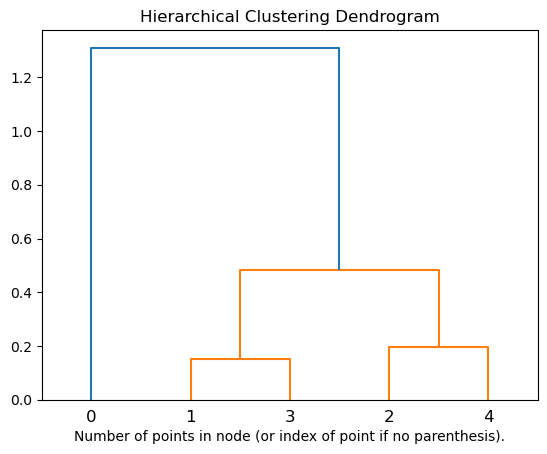

In [1058]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)


# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)

model = model.fit((np.array(vqpca.A)[:, :, 0]))
plt.title("Hierarchical Clustering Dendrogram")
# plot the top three levels of the dendrogram
plot_dendrogram(model, truncate_mode="level", p=2)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()



In [1059]:
# Function to create aggregated eigenvectors
def agg_eigenvectors(eigenvectors, children, centroids):
    # For each child, create new aggregated vector and centroid
    for child in children:
        agg_row = np.expand_dims(np.mean(eigenvectors[[child[0], child[1]], :], axis=0), axis=0)
        eigenvectors = np.vstack([eigenvectors, agg_row])
        agg_cen = np.mean(centroids[[child[0], child[1]], :], axis=0).T
        centroids = np.vstack([centroids, agg_cen])
    # Returns a new list of old eigenvectors, centroids + aggregated eigenvectors, centroids
    return eigenvectors, centroids

eigenvectors = np.stack((vqpca.A))
centroids = get_centroids(X, vqpca.idx)

e, c = agg_eigenvectors(eigenvectors, model.children_, centroids)

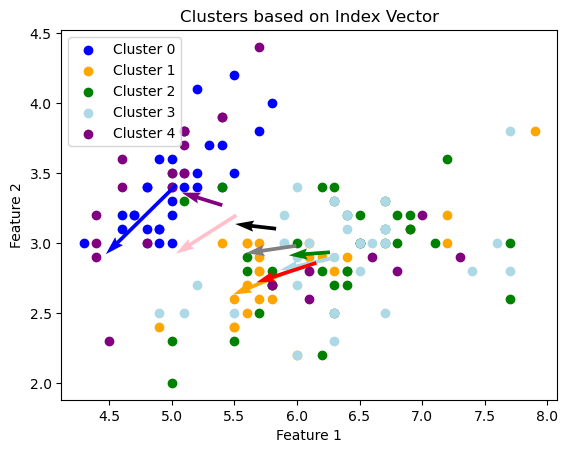

In [1060]:
# Access the VQPCA clustering solution:
idx = vqpca.idx

# Separate data points based on cluster index
cluster_0 = X[idx == 0]
cluster_1 = X[idx == 1]
cluster_2 = X[idx == 2]
cluster_3 = X[idx == 3]
cluster_4 = X[idx == 4]

# Plot the clusters
plt.scatter(cluster_0[:, 0], cluster_0[:, 1], label='Cluster 0', color='blue')
plt.scatter(cluster_1[:, 0], cluster_1[:, 1], label='Cluster 1', color='orange')
plt.scatter(cluster_2[:, 0], cluster_2[:, 1], label='Cluster 2', color='green')
plt.scatter(cluster_3[:, 0], cluster_3[:, 1], label='Cluster 3', color='lightblue')
plt.scatter(cluster_4[:, 0], cluster_4[:, 1], label='Cluster 4', color='purple')

# Plot the eigenvectors
plt.quiver(c[:, 0], c[:, 1], e[:, 0, 0], e[:, 1, 0], color=['blue', 'orange', 'green', 'lightblue', 'purple', 'red', 'black', 'gray', 'pink'], scale=5)

# Add labels and title
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Clusters based on Index Vector')

# Show legend
plt.legend()

# Show the plot
plt.show()